In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:

# --- 1. Load the Dataset ---
print("Loading dataset...")
df = pd.read_csv('options_dataset.csv')
print(f"Dataset loaded successfully with {len(df)} rows.")

# Display the first few rows to inspect the data
df.head()

Loading dataset...
Dataset loaded successfully with 118274 rows.


,moneyness,timeToExpiration,impliedVolatility,riskFreeRate,marketPrice
0,0.869774,0.000000,1.934571,0.05,37.600
1,6.585429,0.057534,0.000010,0.05,161.700
2,0.781322,0.057534,0.000010,0.05,58.675
3,0.720281,0.057534,2.555424,0.05,122.475
4,0.698455,0.057534,2.395390,0.05,126.950


In [13]:

# --- 2. Define Features (X) and Target (y) ---
features = [
    'moneyness',
    'timeToExpiration', 
    'impliedVolatility', 
    'riskFreeRate'
    ]
target = 'marketPrice'
X = df[features]
y = df[target]

In [14]:

# --- 3. Split Data into Training and Testing Sets ---
# We'll train the model on 80% of the data and test its performance
# on the 20% it has never seen before.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Data split into {len(X_train)} training samples and {len(X_test)} testing samples.")

Data split into 94619 training samples and 23655 testing samples.


In [15]:

# --- 4. Initialize and Train the Random Forest Model ---
print("Training the Random Forest model... (This may take a few moments)")
# n_estimators: The number of trees in the forest. 100 is a good start.
# n_jobs=-1: This tells the model to use all available CPU cores for training, making it much faster.
# random_state=42: Ensures that your results are reproducible.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True)

# Fit the model to the training data
rf_model.fit(X_train, y_train)
print("Model training complete.")
print(f"Out-of-Bag Score: {rf_model.oob_score_:.4f}")

Training the Random Forest model... (This may take a few moments)
Model training complete.
Out-of-Bag Score: 0.9560


In [16]:

# --- 5. Make Predictions on the Test Set ---
print("Making predictions on the test set...")
predictions = rf_model.predict(X_test)

print("\n--- Model Performance Evaluation ---")
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error (MAE): ${mae:.4f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print("------------------------------------")

Making predictions on the test set...

--- Model Performance Evaluation ---
Mean Absolute Error (MAE): $12.7712
Root Mean Squared Error (RMSE): $30.4893
R-squared (R²): 0.9576
------------------------------------


### 7. Visualize Predictions vs. Actuals

A scatter plot is a great way to see how well the model's predictions align with the true market prices. A perfect model would have all the points lying on the red `y=x` line.

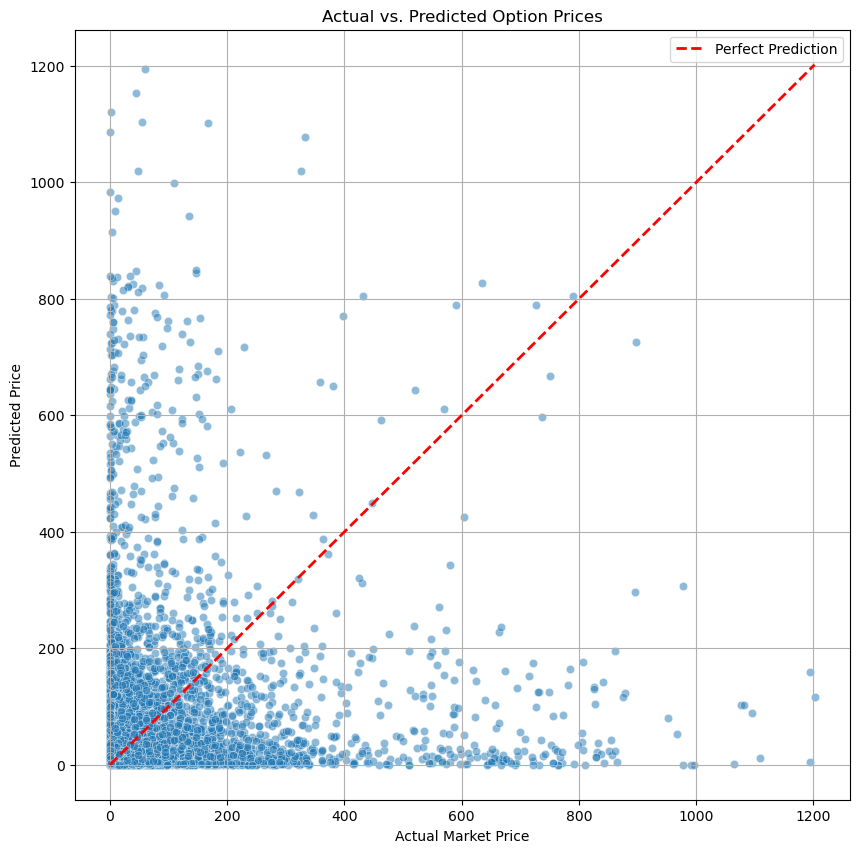

In [17]:
# For performance, we'll only plot a random sample of 5000 points
sample_indices = np.random.choice(X_test.index, 5000, replace=False)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_test.loc[sample_indices], y=predictions[X_test.index.isin(sample_indices)], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Market Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Option Prices')
plt.legend()
plt.grid(True)
plt.show()

--- Feature Importance ---
             Feature  Importance
0          moneyness    0.613771
2  impliedVolatility    0.333487
1   timeToExpiration    0.052742
3       riskFreeRate    0.000000
--------------------------


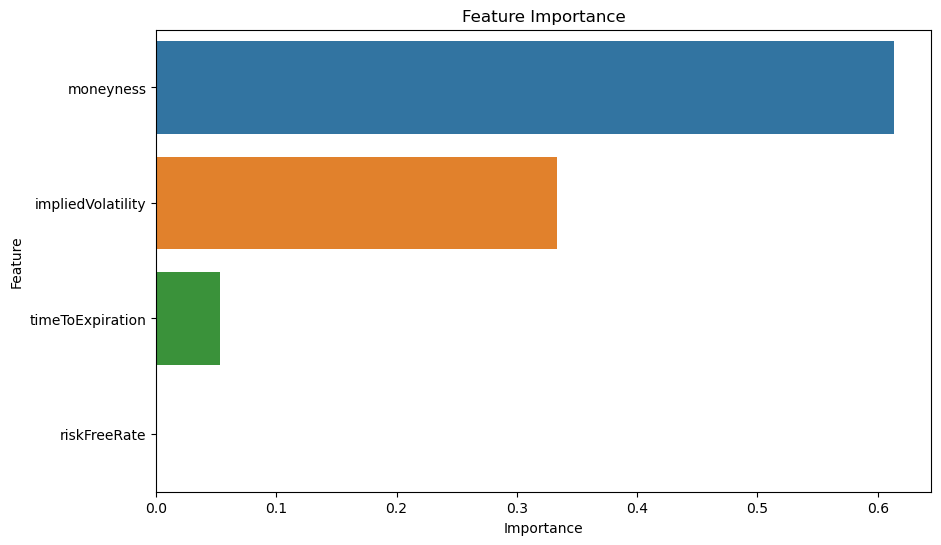

In [19]:
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("--- Feature Importance ---")
print(feature_importance_df)
print("--------------------------")

# Visualize Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()